In [1]:
from __future__ import annotations
import csv
import json
import re
from dataclasses import dataclass
from pathlib import Path
from typing import List

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

def find_repo_root(start: Path | None = None) -> Path:
    """Walk upward until Cargo.toml is found to anchor relative paths."""
    current = (start or Path.cwd()).resolve()
    for candidate in [current, *current.parents]:
        if (candidate / "Cargo.toml").exists():
            return candidate
    raise RuntimeError("Could not locate repository root (missing Cargo.toml)")


REPO_ROOT = find_repo_root()
EVAL_DIR = REPO_ROOT / "python" / "evaluation"
REFERENCE_DIR = EVAL_DIR / "reference-data"

@dataclass
class BandData:
    distances: List[float]
    bands: List[List[float]]
    k_nodes: List[dict]

def load_mpb(path: Path) -> BandData:
    data = json.loads(path.read_text())
    distances = [kp["distance"] for kp in data["k_path"]]
    bands = [list(band) for band in zip(*data["bands"])]
    return BandData(distances, bands, data.get("k_nodes", []))

def load_mpb2d_csv(path: Path) -> BandData:
    with path.open() as handle:
        reader = csv.DictReader(handle)
        distances: List[float] = []
        band_columns = [name for name in reader.fieldnames if name.startswith("band")]
        bands = [[] for _ in band_columns]
        for row in reader:
            distances.append(float(row["k_distance"]))
            for idx, column in enumerate(band_columns):
                value = row[column]
                bands[idx].append(float(value) if value else float("nan"))
    return BandData(distances, bands, [])

In [2]:
# High-res square lattice: eps_bg=6, r/a=0.3, res=64, k=10/leg, 8 bands
DATASET_FILES = {
    ("mpb", "TE"): REFERENCE_DIR / "square_te_eps6_r0p3_res64_k10_b8_mpb.json",
    ("mpb", "TM"): REFERENCE_DIR / "square_tm_eps6_r0p3_res64_k10_b8_mpb.json",
    ("mpb2d", "TE"): REFERENCE_DIR / "square_te_eps6_r0p3_res64_k10_b8_mpb2d.csv",
    ("mpb2d", "TM"): REFERENCE_DIR / "square_tm_eps6_r0p3_res64_k10_b8_mpb2d.csv",
}

DATASET_LOADERS = {
    "mpb": load_mpb,
    "mpb2d": load_mpb2d_csv,
}

POL_COLORS = {"TE": "tab:orange", "TM": "tab:blue"}
PANEL_TITLES = {"mpb": "MPB (reference)", "mpb2d": "mpb2d-cli"}

# mpb2d uses reversed TE/TM convention compared to MPB
def swap_pol(pol: str) -> str:
    """Swap TE <-> TM for mpb2d convention."""
    return "TM" if pol == "TE" else "TE"

def load_dataset(dataset: str, pol: str) -> BandData:
    key = dataset.lower()
    pol_key = pol.upper()
    # Swap polarization for mpb2d to match MPB convention
    if key == "mpb2d":
        pol_key = swap_pol(pol_key)
    path = DATASET_FILES[(key, pol_key)]
    loader = DATASET_LOADERS[key]
    return loader(path)

def extract_node_metadata():
    try:
        ref = load_dataset("mpb", "TE")
    except FileNotFoundError:
        return [], []
    if not ref.k_nodes:
        return [], []
    positions = [node.get("distance", idx) for idx, node in enumerate(ref.k_nodes)]
    labels = [node.get("label", f"K{idx}") for idx, node in enumerate(ref.k_nodes)]
    return positions, labels

node_positions, node_labels = extract_node_metadata()

def align_distances(distances):
    if not distances:
        return []
    values = np.asarray(distances, dtype=float)
    values = values - values[0]
    span = values[-1] if values[-1] != 0 else 1.0
    target_span = node_positions[-1] if node_positions else span
    scale = target_span / span if span else 1.0
    return (values * scale).tolist()

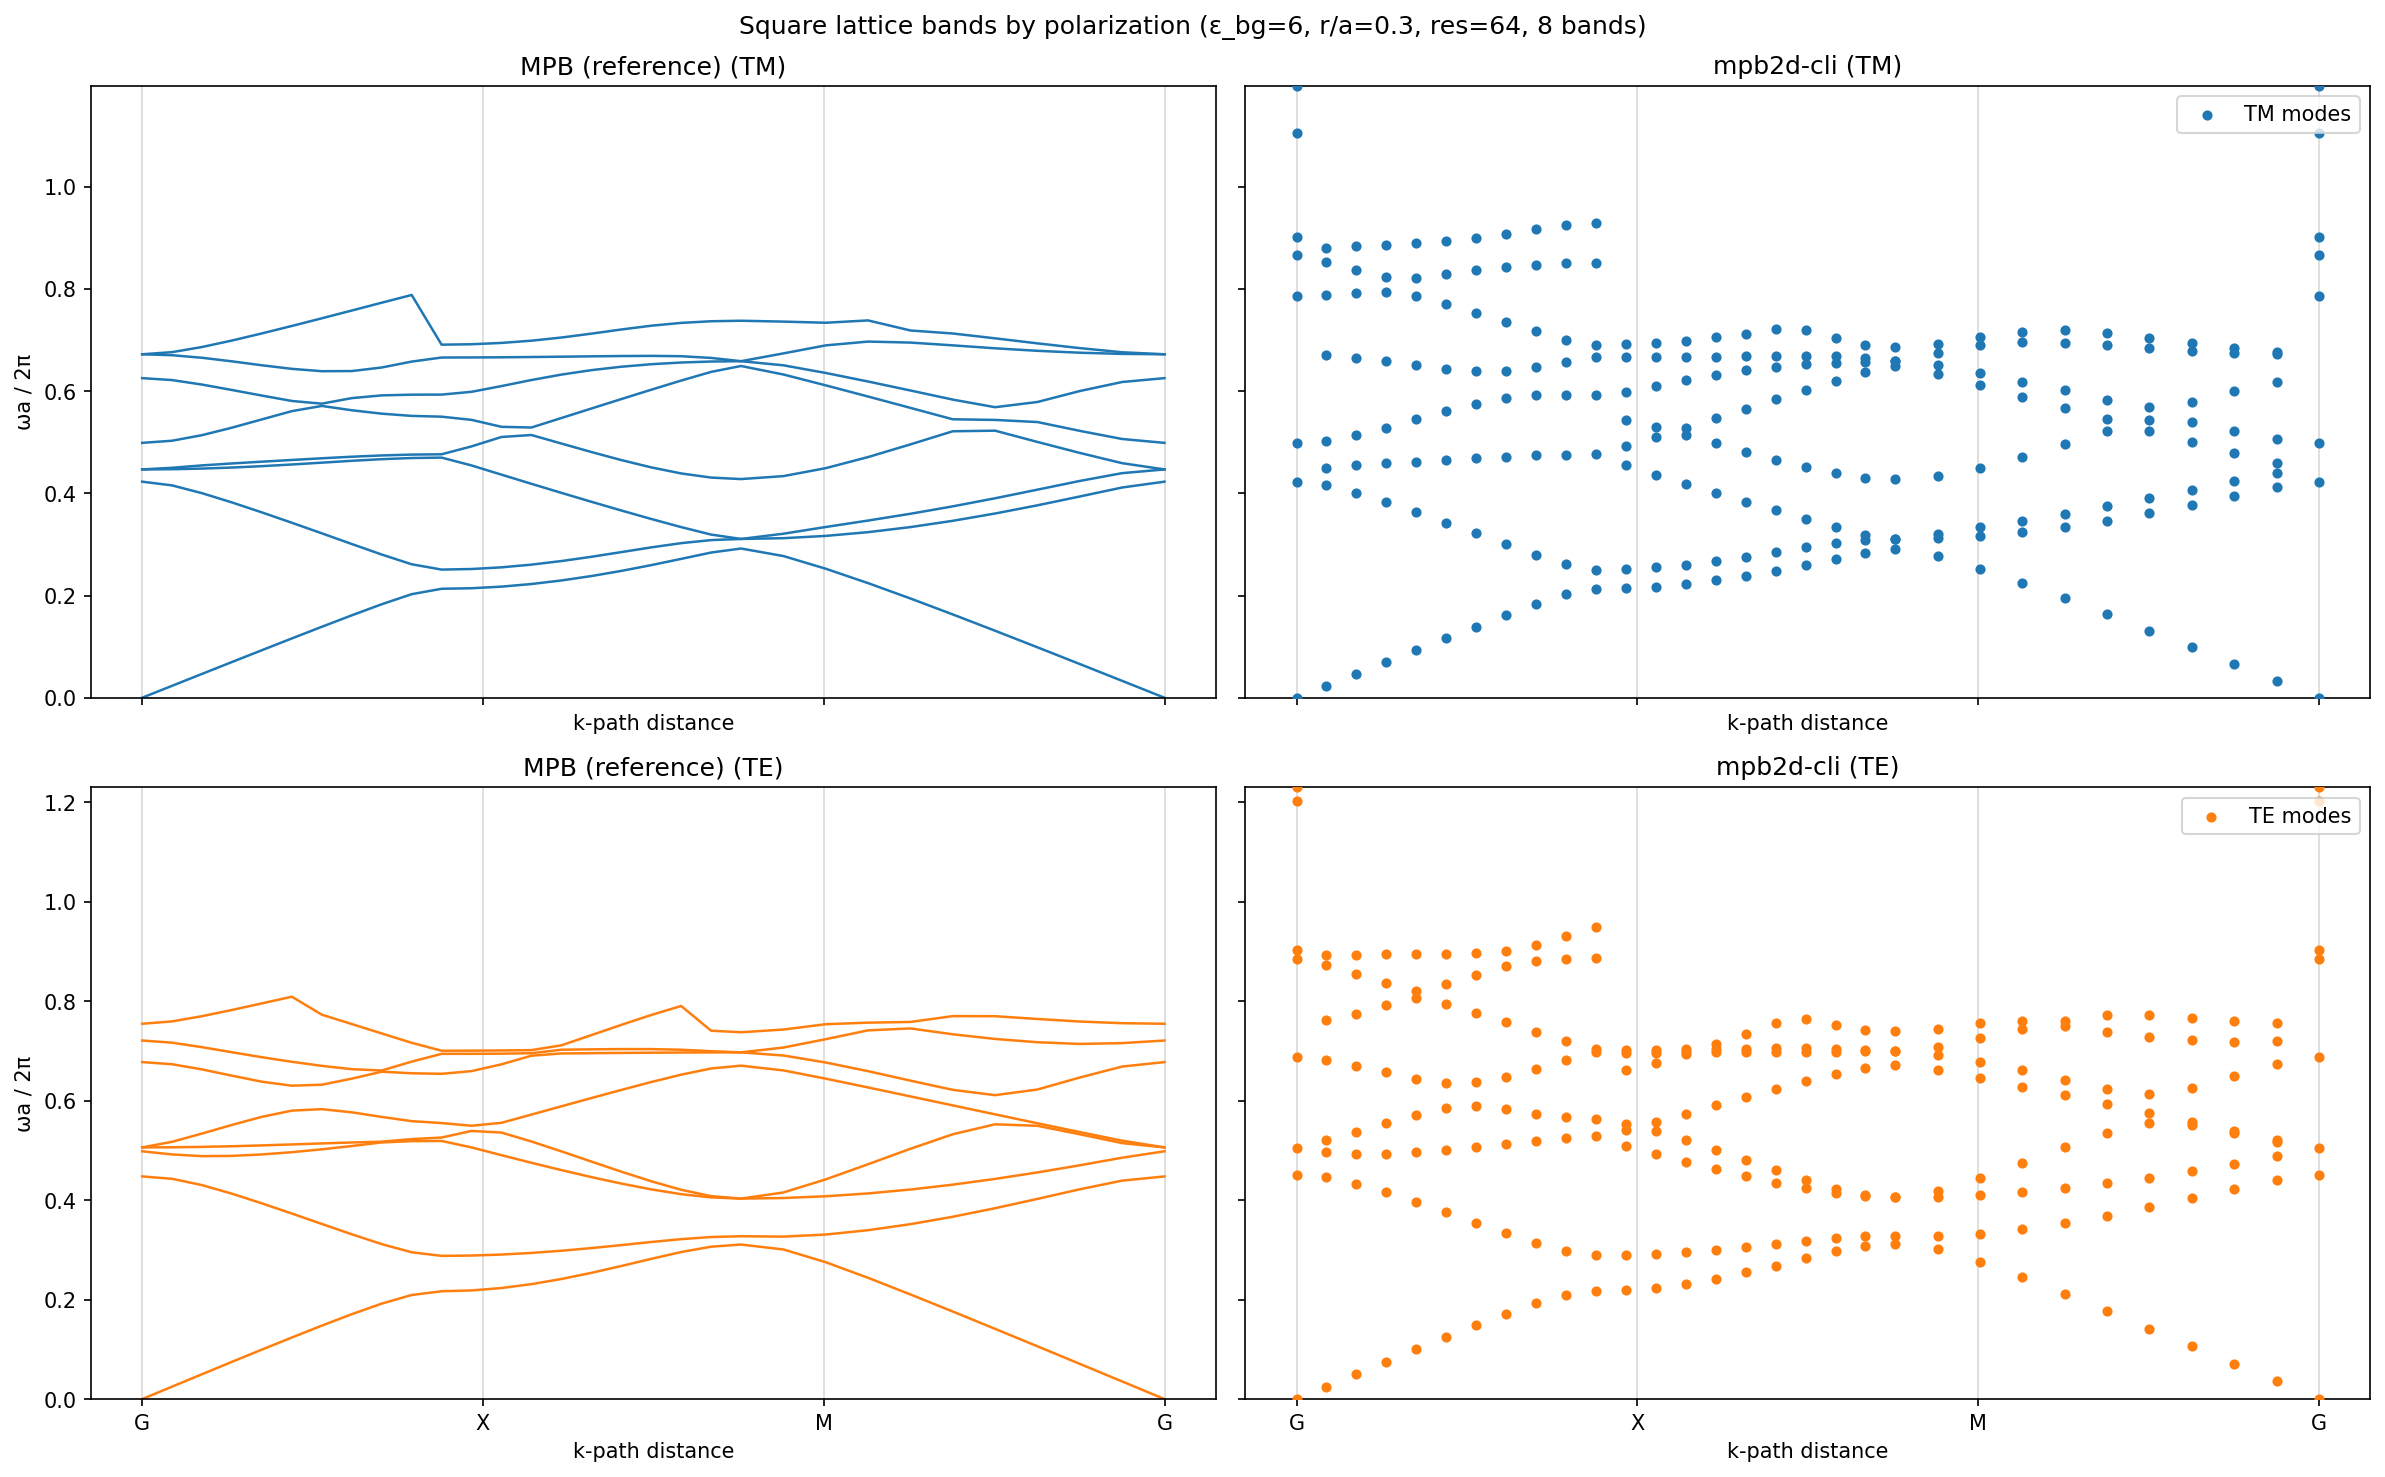

In [3]:
pol_order = ["TM", "TE"]
dataset_order = ["mpb", "mpb2d"]

fig, axes = plt.subplots(
    2,
    2,
    figsize=(16, 10),
    sharex=True,
    sharey="row",
    dpi=150,
 )

row_limits = {pol: [float("inf"), float("-inf")] for pol in pol_order}

for row_idx, pol in enumerate(pol_order):
    for col_idx, dataset in enumerate(dataset_order):
        ax = axes[row_idx, col_idx]
        data = load_dataset(dataset, pol)
        distances = align_distances(data.distances)

        for band_idx, band in enumerate(data.bands):
            label = f"{pol} modes" if band_idx == 0 else None
            
            # Use dots for mpb2d, lines for mpb
            if dataset == "mpb2d":
                ax.scatter(
                    distances,
                    band,
                    color=POL_COLORS[pol],
                    s=15,
                    label=label,
                    zorder=3,
                )
            else:
                ax.plot(
                    distances,
                    band,
                    color=POL_COLORS[pol],
                    linewidth=1.2,
                    label=label,
                )

            finite_vals = [value for value in band if not (value != value)]
            if finite_vals:
                row_limits[pol][0] = min(row_limits[pol][0], min(finite_vals))
                row_limits[pol][1] = max(row_limits[pol][1], max(finite_vals))

        if node_positions:
            ax.set_xticks(node_positions)
            ax.set_xticklabels(node_labels)
            for pos in node_positions:
                ax.axvline(pos, color="0.85", linewidth=0.8, zorder=0)

        ax.set_title(f"{PANEL_TITLES[dataset]} ({pol})")
        ax.set_xlabel("k-path distance")
        if col_idx == 0:
            ax.set_ylabel("ωa / 2π")

    axes[row_idx, 1].legend(loc="upper right")

for row_idx, pol in enumerate(pol_order):
    y_min, y_max = row_limits[pol]
    if y_min < y_max:
        for ax in axes[row_idx]:
            ax.set_ylim(y_min, y_max)

fig.suptitle("Square lattice bands by polarization (ε_bg=6, r/a=0.3, res=64, 8 bands)")
fig.tight_layout()
plt.show()

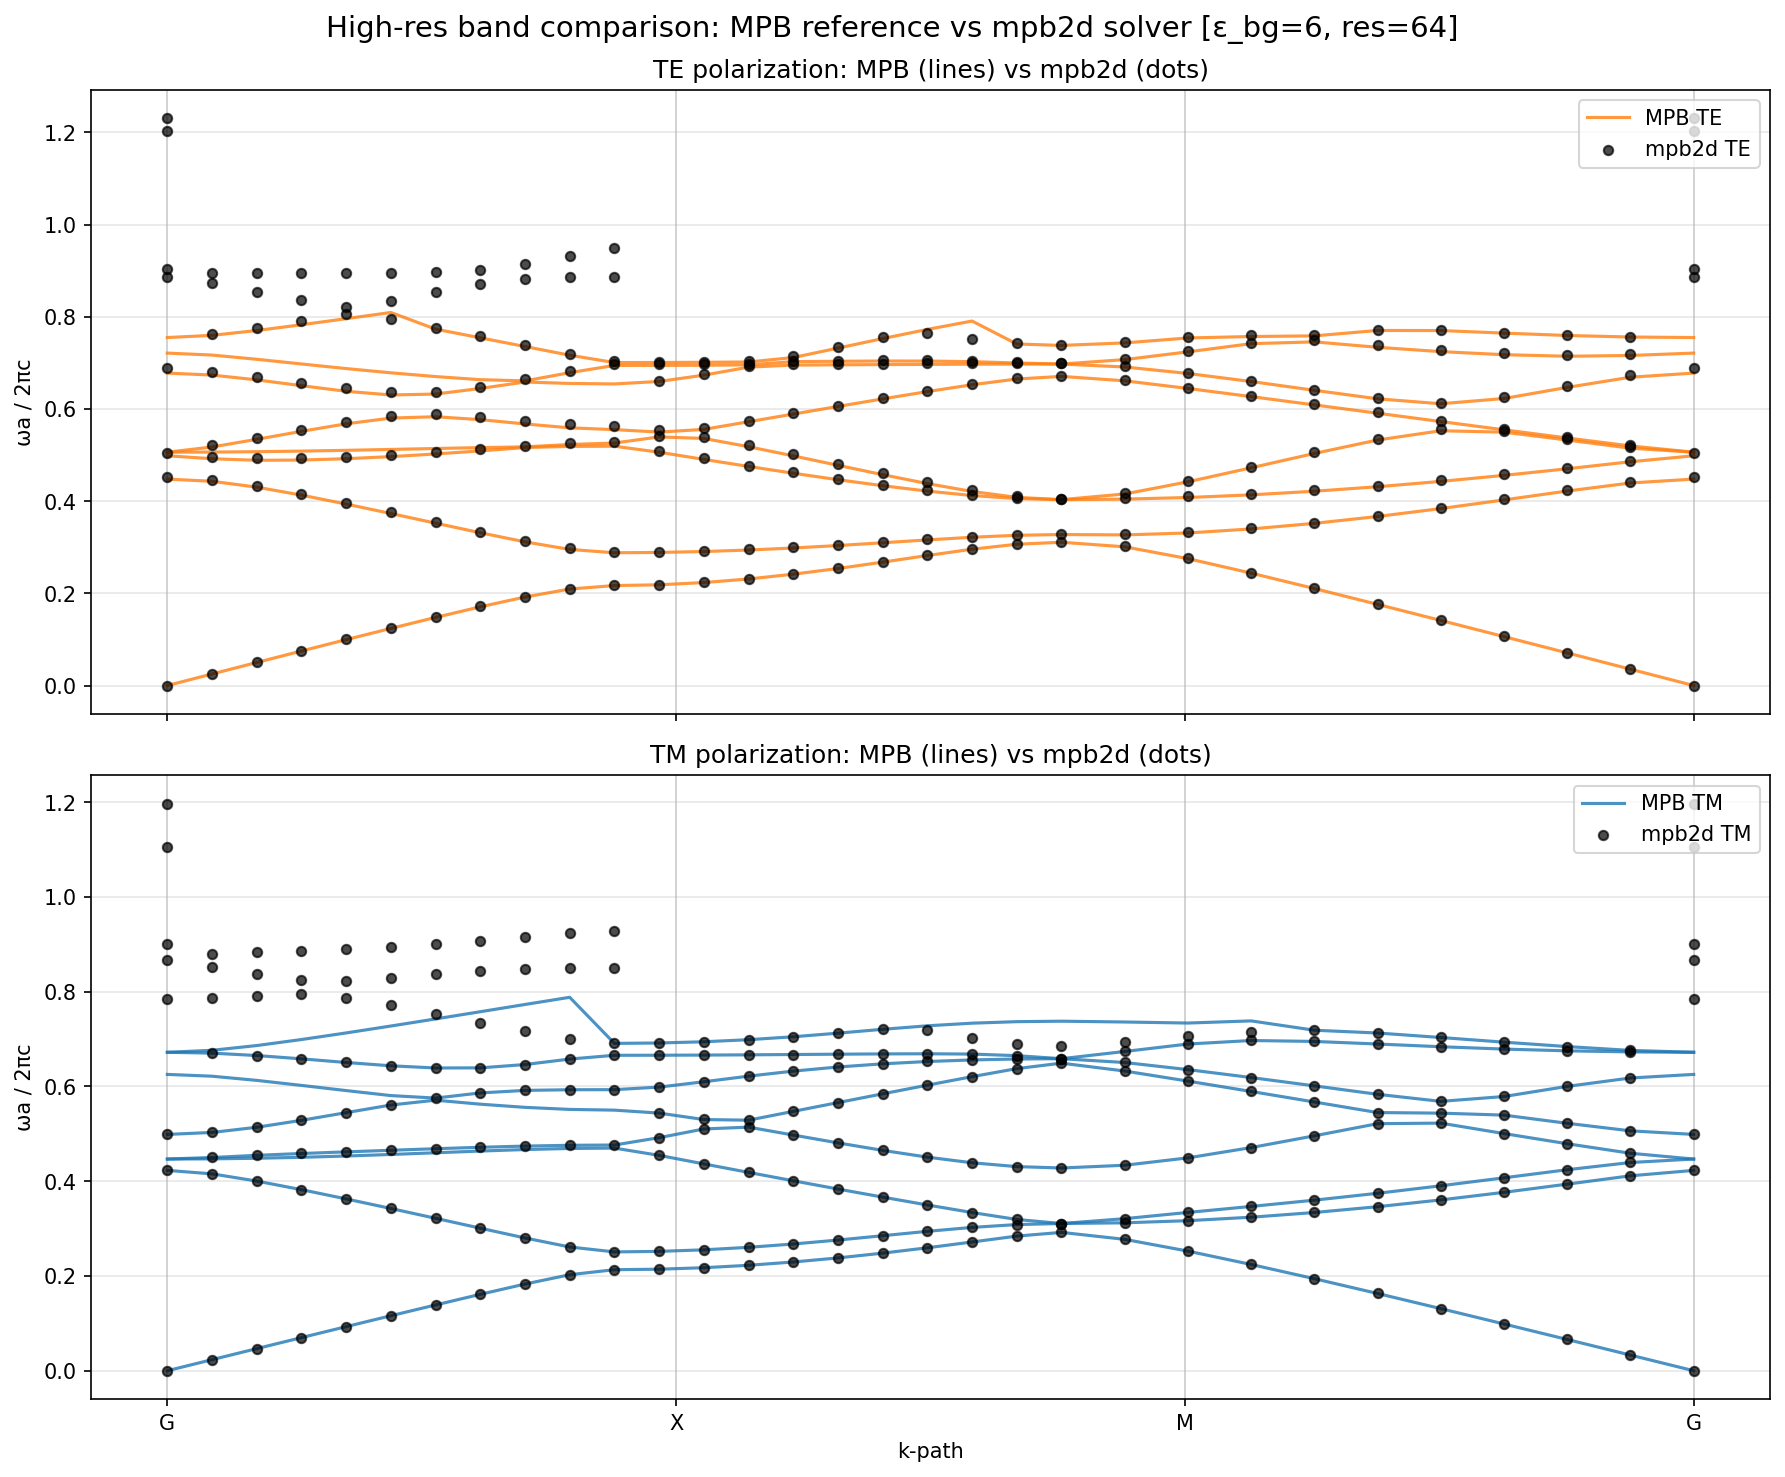

In [4]:
# Merged band comparison: MPB (lines) vs mpb2d (dots) for both polarizations
# Same polarization comparison (TE vs TE, TM vs TM) - mpb2d swap handled in load_dataset

fig, axes = plt.subplots(2, 1, figsize=(12, 10), sharex=True, dpi=150)

for row_idx, pol in enumerate(["TE", "TM"]):
    ax = axes[row_idx]
    
    # Plot MPB reference as lines
    mpb_data = load_dataset("mpb", pol)
    mpb_distances = align_distances(mpb_data.distances)
    for band_idx, band in enumerate(mpb_data.bands):
        label = f"MPB {pol}" if band_idx == 0 else None
        ax.plot(
            mpb_distances,
            band,
            color=POL_COLORS[pol],
            linewidth=1.5,
            label=label,
            alpha=0.8,
        )
    
    # Plot mpb2d with same polarization (swap handled internally)
    mpb2d_data = load_dataset("mpb2d", pol)
    mpb2d_distances = align_distances(mpb2d_data.distances)
    for band_idx, band in enumerate(mpb2d_data.bands):
        label = f"mpb2d {pol}" if band_idx == 0 else None
        ax.scatter(
            mpb2d_distances,
            band,
            color="black",
            s=20,
            marker="o",
            label=label,
            zorder=3,
            alpha=0.7,
        )
    
    # Add high-symmetry point markers
    if node_positions:
        ax.set_xticks(node_positions)
        ax.set_xticklabels(node_labels)
        for pos in node_positions:
            ax.axvline(pos, color="0.85", linewidth=0.8, zorder=0)
    
    ax.set_ylabel("ωa / 2πc")
    ax.set_title(f"{pol} polarization: MPB (lines) vs mpb2d (dots)")
    ax.legend(loc="upper right")
    ax.grid(True, alpha=0.3)

axes[-1].set_xlabel("k-path")
fig.suptitle("High-res band comparison: MPB reference vs mpb2d solver [ε_bg=6, res=64]", fontsize=14)
fig.tight_layout()
plt.show()

In [5]:
# ============================================================================
# Data loaders for epsilon and iteration traces
# ============================================================================

EPSILON_CSV = REFERENCE_DIR / "compare_square_highres_epsilon.csv"

# Note: mpb2d TE/TM convention is reversed, so we swap the file mapping
# mpb2d "TE" file contains what MPB calls "TM" and vice versa
ITERATION_CSV_TE = REFERENCE_DIR / "compare_square_highres_tm_iterations.csv"  # swapped!
ITERATION_CSV_TM = REFERENCE_DIR / "compare_square_highres_te_iterations.csv"  # swapped!


def load_epsilon_data(path: Path) -> pd.DataFrame:
    """Load epsilon CSV with raw and smoothed values."""
    if not path.exists():
        raise FileNotFoundError(f"Epsilon CSV not found: {path}\nRun: make compare_square_highres")
    return pd.read_csv(path)


def reshape_epsilon_grid(df: pd.DataFrame, column: str) -> tuple[np.ndarray, np.ndarray, np.ndarray]:
    """Reshape epsilon data into a 2D grid for plotting."""
    ordered = df.sort_values(["iy", "ix"])
    nx = int(ordered["ix"].max()) + 1
    ny = int(ordered["iy"].max()) + 1
    grid = ordered[column].to_numpy().reshape(ny, nx)
    
    # Get fractional coordinates
    xs = ordered[ordered["iy"] == 0]["frac_x"].to_numpy()
    ys = ordered[ordered["ix"] == 0]["frac_y"].to_numpy()
    return xs, ys, grid


def load_iteration_data(path: Path) -> pd.DataFrame | None:
    """Load iteration CSV with per-band convergence data."""
    if not path.exists():
        print(f"Iteration CSV not found: {path}")
        print("Run: make compare_square_highres")
        return None
    return pd.read_csv(path)


def parse_iteration_bands(df: pd.DataFrame) -> dict:
    """Parse iteration data into per-band arrays."""
    # Find band columns
    band_cols = [c for c in df.columns if c.endswith("_residual")]
    num_bands = len(band_cols)
    
    result = {
        "iterations": df["iteration"].to_numpy(),
        "eigenvalues": [],
        "frequencies": [],
        "residuals": [],
    }
    
    for b in range(1, num_bands + 1):
        result["eigenvalues"].append(df[f"band{b}_eigenvalue"].to_numpy())
        result["frequencies"].append(df[f"band{b}_frequency"].to_numpy())
        result["residuals"].append(df[f"band{b}_residual"].to_numpy())
    
    return result

In [6]:
# ============================================================================
# Convergence plots: Residuals and Eigenvalues vs Iteration
# ============================================================================
# Plot convergence data for TE and TM side by side

iteration_data = {}
for pol, path in [("TE", ITERATION_CSV_TE), ("TM", ITERATION_CSV_TM)]:
    df = load_iteration_data(path)
    if df is not None:
        # Filter to k_index=0 for a single representative k-point
        df_k0 = df[df["k_index"] == 0].copy()
        if len(df_k0) > 0:
            iteration_data[pol] = parse_iteration_bands(df_k0)

if not iteration_data:
    print("No iteration data available. Generate it with:")
    print("  cd python/evaluation && make compare_square_highres")
else:
    # Create 2x2 grid: rows = [Residuals, Eigenvalues], cols = [TE, TM]
    fig, axes = plt.subplots(2, 2, figsize=(14, 10), dpi=150)
    
    for col_idx, pol in enumerate(["TE", "TM"]):
        if pol not in iteration_data:
            for row_idx in range(2):
                axes[row_idx, col_idx].text(0.5, 0.5, f"No {pol} data", 
                    ha="center", va="center", transform=axes[row_idx, col_idx].transAxes)
            continue
        
        data = iteration_data[pol]
        iters = data["iterations"]
        num_bands = len(data["residuals"])
        
        # --- Residuals (top row) ---
        ax_res = axes[0, col_idx]
        for b in range(num_bands):
            ax_res.semilogy(iters, data["residuals"][b], 
                           color=POL_COLORS[pol], alpha=0.2, linewidth=0.8)
        # Average residual
        avg_residual = np.nanmean(data["residuals"], axis=0)
        ax_res.semilogy(iters, avg_residual, color=POL_COLORS[pol], 
                       linewidth=2.5, label=f"avg ({pol})")
        ax_res.set_title(f"{pol} Residuals (k=0)")
        ax_res.set_xlabel("Iteration")
        ax_res.set_ylabel("Relative Residual")
        ax_res.grid(True, which="both", linestyle=":", alpha=0.5)
        ax_res.legend(loc="upper right")
        ax_res.set_ylim(1e-8, 10)
        
        # --- Eigenvalues (bottom row) ---
        ax_eig = axes[1, col_idx]
        for b in range(num_bands):
            ax_eig.plot(iters, data["frequencies"][b], 
                       color=POL_COLORS[pol], alpha=0.2, linewidth=0.8)
        # Average frequency
        avg_freq = np.nanmean(data["frequencies"], axis=0)
        ax_eig.plot(iters, avg_freq, color=POL_COLORS[pol], 
                   linewidth=2.5, label=f"avg ({pol})")
        ax_eig.set_title(f"{pol} Frequencies (k=0)")
        ax_eig.set_xlabel("Iteration")
        ax_eig.set_ylabel("ωa / 2πc")
        ax_eig.grid(True, linestyle=":", alpha=0.5)
        ax_eig.legend(loc="lower right")
    
    fig.suptitle("LOBPCG Convergence: Residuals and Frequencies vs Iteration [res=64]", fontsize=14)
    fig.tight_layout()
    plt.show()

Iteration CSV not found: /home/renlephy/mpb-gpu-2D/python/evaluation/reference-data/compare_square_highres_tm_iterations.csv
Run: make compare_square_highres
Iteration CSV not found: /home/renlephy/mpb-gpu-2D/python/evaluation/reference-data/compare_square_highres_te_iterations.csv
Run: make compare_square_highres
No iteration data available. Generate it with:
  cd python/evaluation && make compare_square_highres


In [7]:
# ============================================================================
# Epsilon plots: Raw vs Smoothed side by side
# ============================================================================

try:
    eps_df = load_epsilon_data(EPSILON_CSV)
    
    xs_raw, ys_raw, eps_raw_grid = reshape_epsilon_grid(eps_df, "eps_raw")
    xs_smooth, ys_smooth, eps_smooth_grid = reshape_epsilon_grid(eps_df, "eps_smoothed")
    
    print(f"Epsilon grid: {eps_raw_grid.shape[1]} x {eps_raw_grid.shape[0]}")
    print(f"Raw ε: min={eps_raw_grid.min():.3f}, max={eps_raw_grid.max():.3f}")
    print(f"Smoothed ε: min={eps_smooth_grid.min():.3f}, max={eps_smooth_grid.max():.3f}")
    
    fig, axes = plt.subplots(1, 2, figsize=(14, 5), dpi=150)
    
    # Common colorbar limits
    vmin = min(eps_raw_grid.min(), eps_smooth_grid.min())
    vmax = max(eps_raw_grid.max(), eps_smooth_grid.max())
    
    # Raw epsilon
    mesh_raw = axes[0].pcolormesh(xs_raw, ys_raw, eps_raw_grid, 
                                   shading="nearest", cmap="viridis",
                                   vmin=vmin, vmax=vmax)
    axes[0].set_title("ε(r) Raw [res=64]")
    axes[0].set_xlabel("x (fractional)")
    axes[0].set_ylabel("y (fractional)")
    axes[0].set_aspect("equal")
    fig.colorbar(mesh_raw, ax=axes[0], fraction=0.046, pad=0.02, label="ε")
    
    # Smoothed epsilon
    mesh_smooth = axes[1].pcolormesh(xs_smooth, ys_smooth, eps_smooth_grid, 
                                      shading="nearest", cmap="viridis",
                                      vmin=vmin, vmax=vmax)
    axes[1].set_title("ε(r) Smoothed (mesh_size=4) [res=64]")
    axes[1].set_xlabel("x (fractional)")
    axes[1].set_ylabel("y (fractional)")
    axes[1].set_aspect("equal")
    fig.colorbar(mesh_smooth, ax=axes[1], fraction=0.046, pad=0.02, label="ε")
    
    fig.suptitle("Dielectric function: Raw vs Smoothed [ε_bg=6, res=64]", fontsize=14)
    fig.tight_layout()
    plt.show()
    
except FileNotFoundError as e:
    print(e)

Epsilon CSV not found: /home/renlephy/mpb-gpu-2D/python/evaluation/reference-data/compare_square_highres_epsilon.csv
Run: make compare_square_highres
